# Bayesian Final Project
## Bayesian Switchpoint analysis
### Adriana Alvaro, Madison Chester, Dafni Tiakouri, Arturo Fredes

In [ ]:
!pip install pymc3==3.11.4 arviz==0.11.4 numpy==1.21.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 19.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━

In [ ]:
import pymc3 as pm
import arviz as az

## Shift in Gaussian Distribution

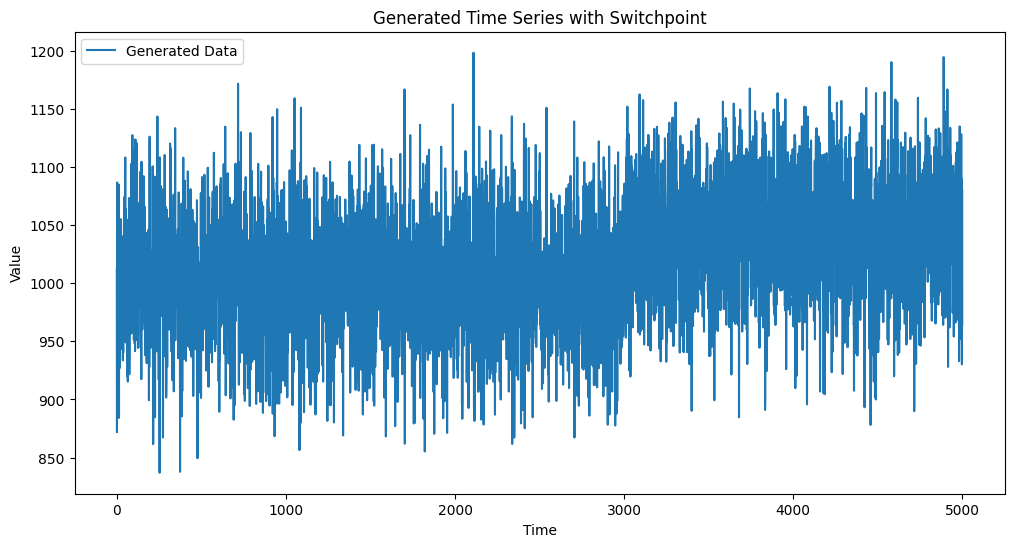

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# set the parameters for the data generation
n_points = 5000  # total number of data points
tau = 3000       # switchpoint location
mu1 = 1000       # mean before the switchpoint
mu2 = 1040       # mean after the switchpoint
sigma = 50       # standard deviation

# generate the data
data = np.zeros(n_points)
data[:tau] = np.random.normal(mu1, sigma, tau)
data[tau:] = np.random.normal(mu2, sigma, n_points - tau)

# plot the generated data
plt.figure(figsize=(12, 6))
plt.plot(data, label='Generated Data')
#plt.axvline(x=tau, color='r', linestyle='--', label='Switchpoint')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Generated Time Series with Switchpoint')
plt.legend()
plt.show()

In [ ]:
def switchpoint_analysis(n_switchpoints):
    with pm.Model() as model:
        # define a function to create a switchpoint variable
        def create_switchpoint(id, lower, upper):
            return pm.DiscreteUniform(f'switchpoint_{id}', lower=lower, upper=upper)

        # define a function to create a rate variable
        def create_rate(id, lower, upper):
            return pm.Uniform(f'rate_{id}', lower=lower, upper=upper)

        # recursively build the switch for the rates
        def build_switch(id):
            if id == 0:
                return pm.math.switch(switchpoints[0] >= days, rates[id], rates[id + 1])
            else:
                return pm.math.switch(switchpoints[id] >= days, build_switch(id - 1), rates[id + 1])

        # create the switchpoints
        switchpoints = [create_switchpoint(0, 0, 5000)]
        for i in range(1, n_switchpoints):
            switchpoints.append(create_switchpoint(i, switchpoints[i - 1] + 1, len(data) - n_switchpoints + i))

        # create the rates
        rates = []
        for i in range(n_switchpoints + 1):
            rates.append(create_rate(i, 900, 1100))

        # generate the days array
        days = np.arange(0, len(data))

        # define the variance
        variance = pm.Uniform('variance', 1, 100)

        # build the mean using the switchpoints and rates
        mean = build_switch(n_switchpoints - 1)

        # define the observation model
        observation = pm.Normal('obs', mu=mean, sigma=variance, observed=data)

    return model

In [ ]:
# create the model with 1 switchpoint
with switchpoint_analysis(1) as model:
    # sample from the posterior distribution
    trace = pm.sample(10000, tune=5000, init='jitter+adapt_diag', return_inferencedata=True)

ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
# summarize the trace with a 95% highest density interval (HDI)
az.summary(trace, hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
switchpoint_0,2862.530,170.669,2536.000,3015.000,116.060,96.821,3.0,11.0,2.22
rate_0,1001.251,0.957,999.463,1003.189,0.019,0.014,2513.0,13988.0,1.01
rate_1,1038.646,2.931,1032.797,1042.829,1.873,1.525,3.0,11.0,1.83
variance,50.870,0.652,49.635,52.179,0.294,0.222,5.0,16.0,1.29


array([[<Axes: title={'center': 'variance'}>,
        <Axes: title={'center': 'variance'}>]], dtype=object)

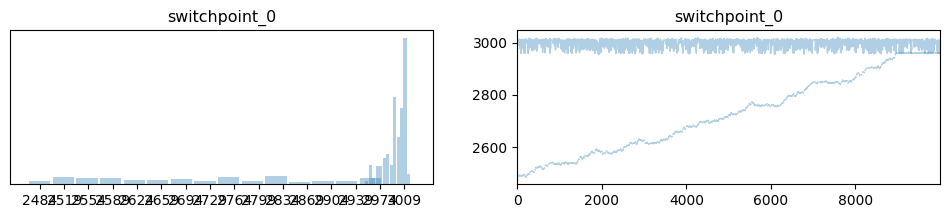

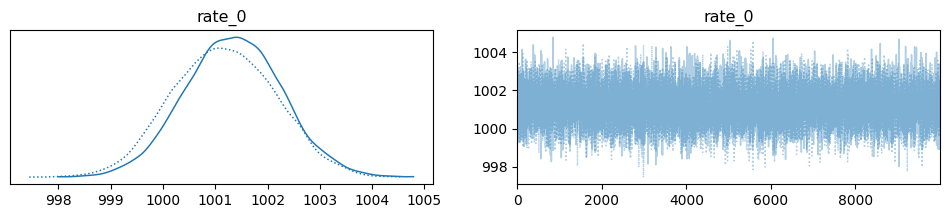

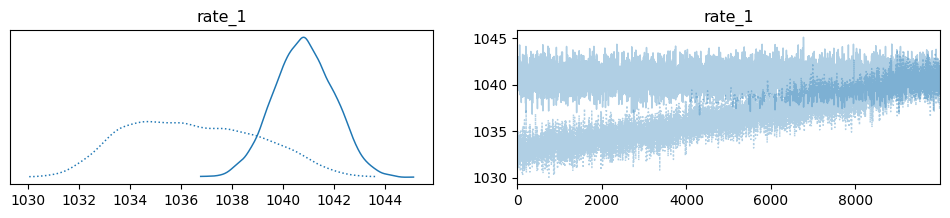

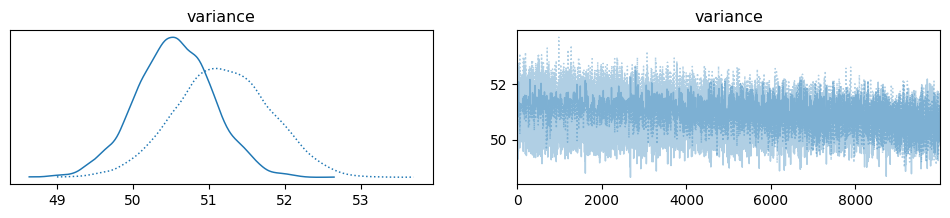

In [ ]:
# plot the trace for the first switchpoint
az.plot_trace(trace, var_names="switchpoint_0")

# plot the trace for the first rate
az.plot_trace(trace, var_names="rate_0")

# plot the trace for the second rate
az.plot_trace(trace, var_names="rate_1")

# plot the trace for the variance
az.plot_trace(trace, var_names="variance")

In [ ]:
# create the model with 1 switchpoint and generate posterior predictive samples
with switchpoint_analysis(1) as model:
    prediction = pm.sample_posterior_predictive(trace, 10000)

/usr/local/lib/python3.10/dist-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [ ]:
def visualization(n_switchpoints):
    # generate an array of plot dates
    plot_dates = np.arange(0, len(data))

    # calculate the posterior quantiles
    posterior_quantile = np.percentile(prediction["obs"], [2.5, 25, 50, 75, 97.5], axis=0)

    # plot the posterior median
    plt.plot(
        plot_dates, posterior_quantile[2, :],
        color='b', label='posterior median', lw=2)

    # fill the 95% quantile range
    plt.fill_between(
        plot_dates, posterior_quantile[0, :], posterior_quantile[4, :],
        color='b', label='95% quantile', alpha=.2)

    # plot the observed data
    plt.plot(
        plot_dates, data,
        '--o', color='k', markersize=3,
        label='Observed', alpha=.8)

    # plot the switchpoints
    for j in range(n_switchpoints):
        plt.vlines(np.median(trace["posterior"]["switchpoint_%s" % j]), data.min(), data.max(), color='C1')

    # adjust x-axis ticks to avoid overlap
    plt.xticks(np.arange(0, len(data), step=len(data) // 10), rotation=45)
    plt.ylabel('Steps', fontsize='large')
    plt.xlabel('Day', fontsize='large')
    plt.title('With %s switchpoints' % n_switchpoints)

    # add the legend
    fontsize = 'medium'
    plt.legend(loc='upper left', fontsize=fontsize)

    # improve layout and show the plot
    plt.tight_layout()
    plt.show()

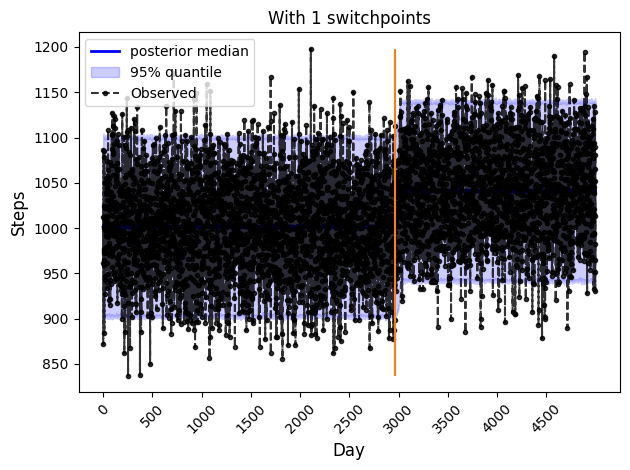

In [ ]:
# usage of the layout function with 1 switchpoint
visualization(1)

## Wave changing amplitude
Now we will try to find the switchpoint in which a wave changes its amplitude.
We will start by generating the data.

In [ ]:
import random
from IPython.core.pylabtools import figsize
import scipy.stats as stats

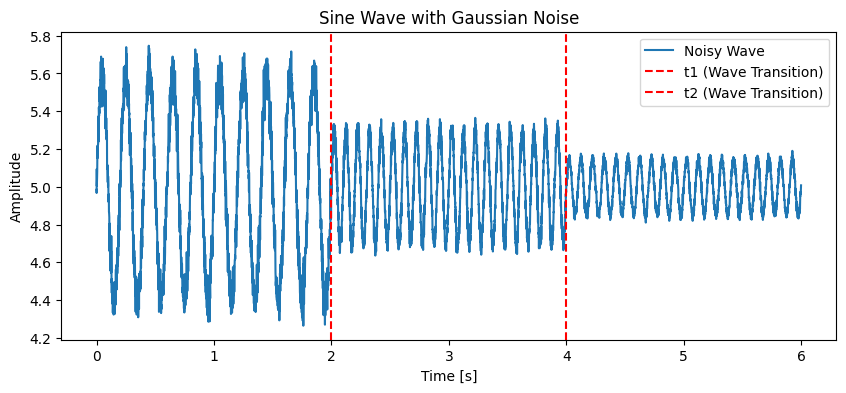

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def create_wave_with_noise(frequency, amplitude, duration, sampling_rate, noise_level):
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    sine_wave = amplitude * np.sin(2 * np.pi * frequency * t)
    noise = np.random.normal(0, noise_level, sine_wave.shape)
    noisy_wave = sine_wave + noise
    return t, noisy_wave

random.seed(420)

# Parameters for the first wave
frequency1 = 5        # Frequency in Hz
amplitude1 = 0.6    # Amplitude of the wave
duration1 = 2.0       # Duration in seconds
sampling_rate = 1000  # Sampling rate in samples per second
noise_level1 = 0.06  # Noise level (standard deviation of the Gaussian noise)

# Parameters for the second wave
frequency2 = 10       # Frequency in Hz
amplitude2 = 0.3      # Amplitude of the wave
duration2 = 2.0       # Duration in seconds
noise_level2 = 0.03    # Noise level (standard deviation of the Gaussian noise)


# Parameters for the second wave
frequency3 = 10       # Frequency in Hz
amplitude3 = 0.15      # Amplitude of the wave
duration3 = 2.0       # Duration in seconds
noise_level3 = 0.015    # Noise level (standard deviation of the Gaussian noise)

# Generate the first wave with noise
t1, noisy_wave1 = create_wave_with_noise(frequency1, amplitude1, duration1, sampling_rate, noise_level1)

# Generate the second wave with noise
t2, noisy_wave2 = create_wave_with_noise(frequency2, amplitude2, duration2, sampling_rate, noise_level2)

# Generate the second wave with noise
t3, noisy_wave3 = create_wave_with_noise(frequency3, amplitude3, duration3, sampling_rate, noise_level3)

wave = np.concatenate((noisy_wave1, noisy_wave2, noisy_wave3))
wave = wave+5 #center in positive values
t_combined = np.linspace(0, duration1 + duration2 + duration3, len(wave), endpoint=False)



# Plot the result
plt.figure(figsize=(10, 4))
plt.plot(t_combined, wave, label='Noisy Wave')
plt.axvline(x=duration1, color='r', linestyle='--', label='t1 (Wave Transition)')
plt.axvline(x=duration1+duration2, color='r', linestyle='--', label='t2 (Wave Transition)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Sine Wave with Gaussian Noise')
plt.legend()
plt.show()

In [ ]:
count_data = pd.Series(wave)

Now we will create a model to find the switchpoint. The priors chosen were:


- $\tau_1 \sim UniformDiscrete(0,3000)$, - $\tau_2 \sim UniformDiscrete(3000,6000)$  for the switchpoints
since there are 6000 steps and they could potentially be any of those. To ensure better con-
vergence we introduced the prior knowledge of the approximate position of the switchpoint
(first or second half of the data)
10


- The prior used for the data is a Normal distribution, and we will have two different distributions for  $\sigma$ since this parameter will be indicative of the distribution shift. For parameters, we also used a uniform distributions as non-informative priors.

- $\sigma_i \sim Uniform(0,10)$
- $\mu \sim Uniform(1,10)$

In [ ]:
def create_wave_model(n_switchpoints):
    with pm.Model() as model:
        # Function to create the distribution for the switchpoint
        def create_switchpoint(id, lower, upper):
            return pm.DiscreteUniform(f'switchpoint_{id}', lower=lower, upper=upper)

        # Function to create distributions for the sigmas
        def create_sigma(id, lower, upper):
            return pm.Uniform(f'sigma_{id}', lower=lower, upper=upper) #average as a free parameter

        # Building the whole function
        def build_switch(id):
            if id == 0:
                return pm.math.switch(switchpoints[0] >= days, rates[id], rates[id+1])
            else:
                return pm.math.switch(switchpoints[id] >= days, build_switch(id-1), rates[id+1])


        #For each switchpoint we will create a distribution
        switchpoints = [create_switchpoint(0, 1000, 3000)] #len(count_data) - n_switchpoints)
        #for i in range(1, n_switchpoints):
        switchpoints.append(create_switchpoint(1, 3000, 6000))

        #For each interval, we will create a distribution for sigma
        rates = []
        for i in range(0, n_switchpoints+1):
            rates.append(create_sigma(i, 0, 10))

        days = np.arange(0, len(count_data))
        mean = pm.Uniform('mean', 1, 10)# mean will remain the same for the whole data

        variance = build_switch(n_switchpoints-1)

        # We chose a normal distribution for our prior due to the wave nature of the data
        observation = pm.Normal('obs',mu=mean, sigma=variance, observed=count_data)

    return model

After building the model, we sample using MCMC via the pymc3 library.

In [ ]:
with create_wave_model(2) as model:
    trace = pm.sample(10000, tune = 5000,
                      init = 'jitter+adapt_diag',
                      chains = 4,
                      return_inferencedata=True)

ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


The switchpoints should be at 2000 and 4000. Looking at the results, we can see that we are pretty close. The mean remains close to 5 as it should, and the variance is also correctly estimated.

In [ ]:
az.summary(trace, hdi_prob=.95) #

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
switchpoint_0,1984.886,3.738,1976.000,1991.000,0.141,0.100,712.0,1195.0,1.00
switchpoint_1,4070.496,101.218,3985.000,4302.000,44.006,33.014,6.0,24.0,1.72
sigma_0,0.430,0.007,0.417,0.444,0.000,0.000,64336.0,30228.0,1.00
sigma_1,0.212,0.005,0.202,0.221,0.002,0.001,10.0,35.0,1.31
sigma_2,0.107,0.002,0.104,0.111,0.000,0.000,56694.0,28911.0,1.00
mean,5.000,0.002,4.996,5.004,0.000,0.000,331.0,22967.0,1.01


We got a good convergence of the model. For the first and second switchpoints, we had no error, getting a NaN (not a number) R hat result.

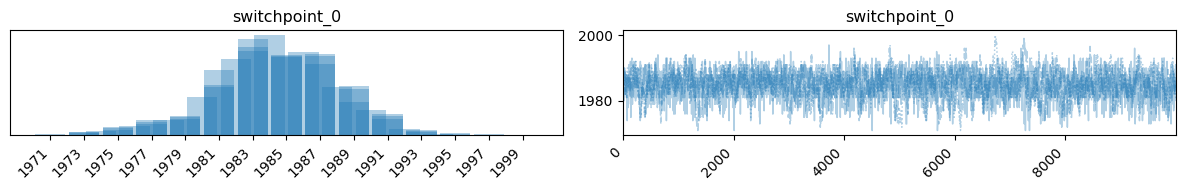

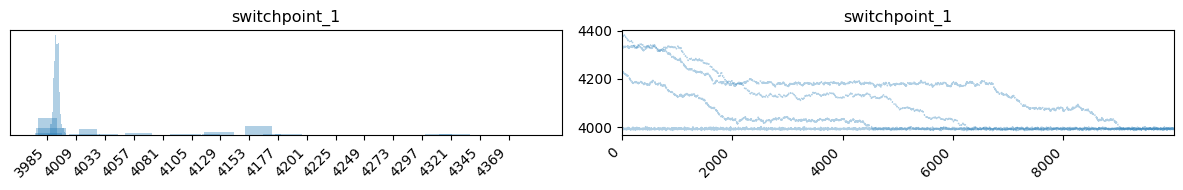

array([[<Axes: title={'center': 'mean'}>,
        <Axes: title={'center': 'mean'}>]], dtype=object)

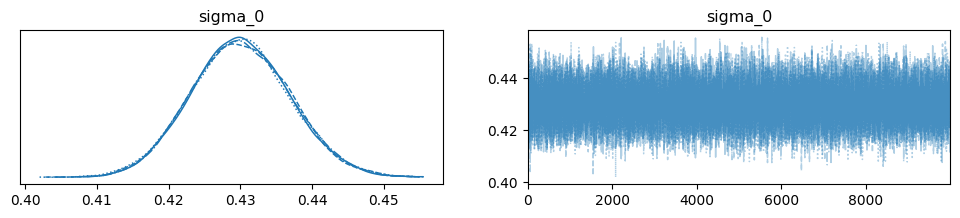

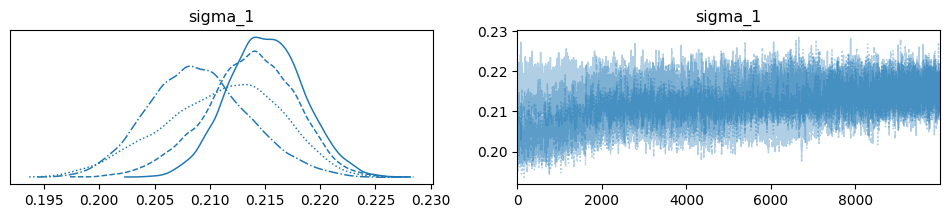

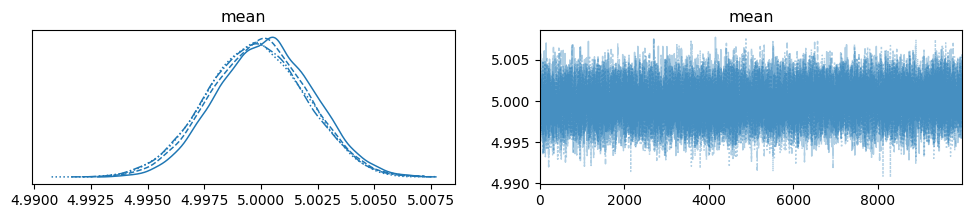

In [ ]:

axes = az.plot_trace(trace,var_names="switchpoint_0")
for ax in axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')


plt.tight_layout()
plt.show()

axes = az.plot_trace(trace,var_names="switchpoint_1")
for ax in axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')


plt.tight_layout()
plt.show()
az.plot_trace(trace,var_names="sigma_0")
az.plot_trace(trace,var_names="sigma_1")
az.plot_trace(trace,var_names="mean")



Let's see the evolution:

In [ ]:
with create_wave_model(2) as model:
        prediction=pm.sample_posterior_predictive(trace, 10000)

/usr/local/lib/python3.10/dist-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [ ]:
def layout (n_switchpoints):
    plot_dates =  np.arange(0, len(count_data))

    posterior_quantile = np.percentile(prediction["obs"], [2.5, 25, 50, 75, 97.5], axis=0)

    # Plot daily number of steps
    plt.plot(
        plot_dates, posterior_quantile[2, :],
        color='b', label='posterior median', lw=2)

    plt.fill_between(
        plot_dates, posterior_quantile[0, :], posterior_quantile[4, :],
        color='b', label='95% quantile', alpha=.2)

    plt.plot(
          plot_dates, count_data,
          '--o', color='k', markersize=3,
          label='Observed', alpha=.8)

    for j in range(0, n_switchpoints):
        plt.vlines(np.median(trace["posterior"]["switchpoint_%s" %(j)]), count_data.min(), count_data.max(), color='C1')

        plt.xticks(np.arange(0, len(count_data), step=len(count_data) // 10), rotation=45)
    plt.ylabel('Amplitude', fontsize='large')
    plt.xlabel('Time(ms)', fontsize='large')
    plt.title('With %s switchpoints'%n_switchpoints)



    fontsize = 'medium'
    plt.legend(loc='upper left', fontsize=fontsize)

    return plt.tight_layout();


If we look at the final plot, we can see that the variance and switchpoints were correctly estimated.

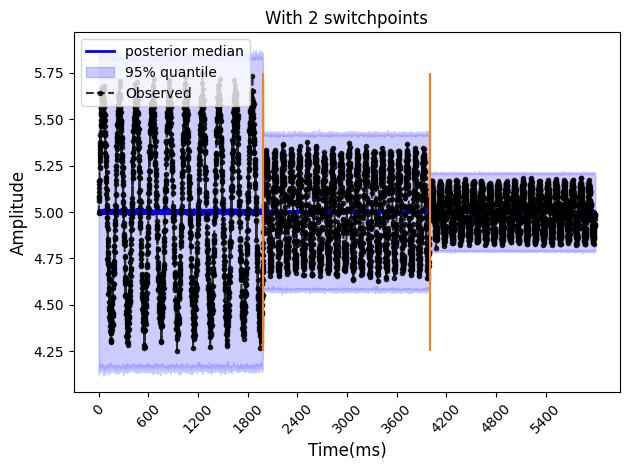

In [ ]:
layout(2)

## Bitcoin Prices and Tesla

February 8th Tesla buys crazy amount of Bitcoins

https://www.bbc.com/mundo/noticias-55988372

March 24th 2021 Elon Musk announces Teslas can be paid with bitcoins

https://computerhoy.com/noticias/motor/elon-musk-anuncia-ya-puede-comprar-tesla-bitcoin-835377

May 13th 2021 Elon Musk announces that it cannot be paid with bitcoins anymore

https://www.bbc.com/mundo/noticias-57096818


### EDA

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Bayesian Statistics/Final project/Datos históricos del Bitcoin.csv'

Mounted at /content/drive


In [ ]:
# read the CSV file into a DataFrame
data = pd.read_csv(file_path)

# define the date format
date_format = '%d.%m.%Y'

# convert the 'Fecha' column to datetime format
data['date_time'] = pd.to_datetime(data["Fecha"], format=date_format)

# sort the DataFrame by the 'date_time' column and reset the index
data = data.sort_values(by='date_time').reset_index()

# rename the 'Último' column to 'value'
data['value'] = data['Último']

# replace commas with semicolons, and then replace dots with commas to convert numbers to float format
data['value'] = data['value'].apply(lambda n: n.replace(',', ';'))
data['value'] = data['value'].apply(lambda n: n.replace('.', ''))
data['value'] = data['value'].apply(lambda n: n.replace(';', '.'))
data['value'] = data['value'].astype(float)

# select and rearrange the columns to keep only 'date_time' and 'value'
cols = ['date_time', 'value']
data = data[cols]

# display the DataFrame
data

,date_time,value
0,2021-01-01,29359.9
1,2021-01-02,32193.3
2,2021-01-03,32958.9
3,2021-01-04,32022.6
4,2021-01-05,33991.5
...,...,...
176,2021-06-26,32243.4
177,2021-06-27,34678.5
178,2021-06-28,34475.9
179,2021-06-29,35834.7


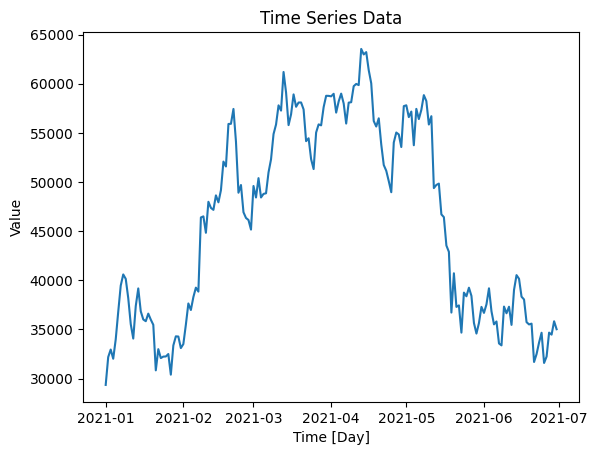

In [ ]:
# plot the time series data
plt.plot(data['date_time'], data['value'])
plt.xlabel('Time [Day]')
plt.ylabel('Value')
plt.title('Time Series Data')
plt.show()

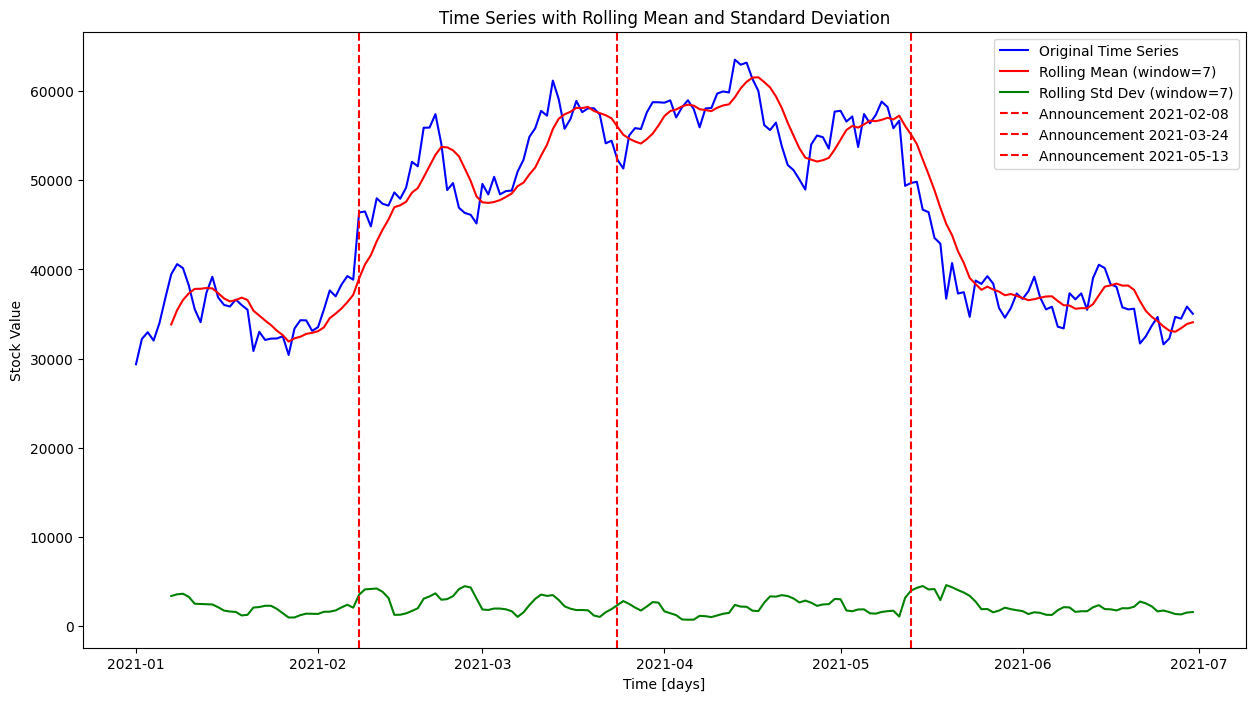

In [ ]:
# define the window size for rolling mean and standard deviation calculation
window_size = 7 # one week

# define key dates for announcements
key_date_0 = '2021-02-08'
key_date_1 = '2021-03-24'
key_date_2 = '2021-05-13'

# convert key dates to date objects
key_date_object_0 = pd.to_datetime(key_date_0).date()
key_date_object_1 = pd.to_datetime(key_date_1).date()
key_date_object_2 = pd.to_datetime(key_date_2).date()

# calculate rolling mean and rolling standard deviation
rolling_mean = data['value'].rolling(window=window_size).mean()
rolling_std = data['value'].rolling(window=window_size).std()

# plot the original time series, rolling mean, and rolling standard deviation
plt.figure(figsize=(15, 8))
plt.plot(data['date_time'], data['value'], label='Original Time Series', color='blue')
plt.plot(data['date_time'], rolling_mean, label=f'Rolling Mean (window={window_size})', color='red')
plt.plot(data['date_time'], rolling_std, label=f'Rolling Std Dev (window={window_size})', color='green')

# add vertical lines for key dates
plt.axvline(x=key_date_object_0, color='r', linestyle='--', label=f'Announcement {key_date_0}')
plt.axvline(x=key_date_object_1, color='r', linestyle='--', label=f'Announcement {key_date_1}')
plt.axvline(x=key_date_object_2, color='r', linestyle='--', label=f'Announcement {key_date_2}')

# add title and labels
plt.title('Time Series with Rolling Mean and Standard Deviation')
plt.xlabel('Time [days]')
plt.ylabel('Stock Value')
plt.legend()
plt.show()

In [ ]:
# subset the data before key_date_0
data_0 = data[data['date_time'] < key_date_0]

# subset the data between key_date_0 and key_date_1
data_1 = data[(data['date_time'] >= key_date_0) & (data['date_time'] < key_date_1)]

# subset the data between key_date_1 and key_date_2
data_2 = data[(data['date_time'] >= key_date_1) & (data['date_time'] < key_date_2)]

# subset the data after key_date_2
data_3 = data[data['date_time'] >= key_date_2]

In [ ]:
data_0.head()

,date_time,value
0,2021-01-01,29359.9
1,2021-01-02,32193.3
2,2021-01-03,32958.9
3,2021-01-04,32022.6
4,2021-01-05,33991.5


In [ ]:
data_1.head()

,date_time,value
38,2021-02-08,46395.7
39,2021-02-09,46508.6
40,2021-02-10,44836.0
41,2021-02-11,47990.7
42,2021-02-12,47371.7


In [ ]:
data_2.head()

,date_time,value
82,2021-03-24,52325.4
83,2021-03-25,51322.3
84,2021-03-26,55036.1
85,2021-03-27,55862.9
86,2021-03-28,55765.2


In [ ]:
data_3.head()

,date_time,value
132,2021-05-13,49704.6
133,2021-05-14,49839.8
134,2021-05-15,46708.8
135,2021-05-16,46426.4
136,2021-05-17,43541.3


In [ ]:
def plot_trend(df, title, col='value'):
    # generate a time index
    t = np.arange(len(df))
    X = sm.add_constant(t)

    # fit the linear trend model
    model = sm.OLS(df[col], X).fit()
    trend = model.predict(X)

    # detrend
    detrended = df[col] - trend

    # plot original series and trend
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(df['date_time'], df[col], label=f'Original Series {title}')
    plt.plot(df['date_time'], trend, label='Trend', color='red')
    plt.title('Original Series')
    plt.legend()

    # plot detrended series
    plt.subplot(2, 1, 2)
    plt.plot(df['date_time'], detrended, label=f'Detrended Series {title}', color='green')
    plt.title('Detrended Series')
    plt.legend()

    plt.tight_layout()
    plt.show()

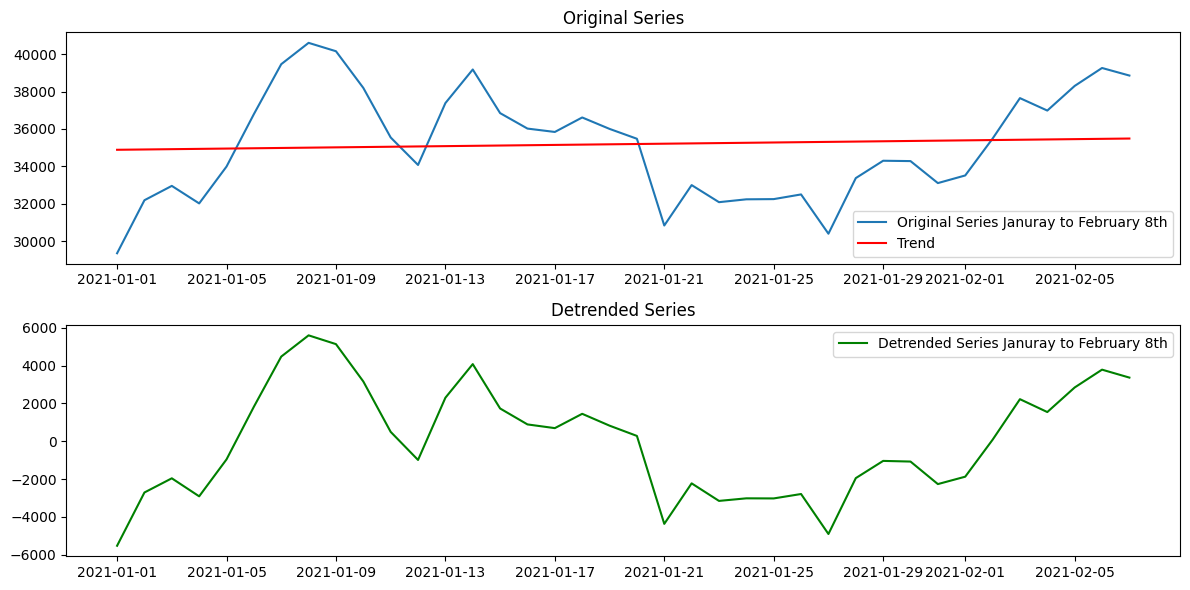

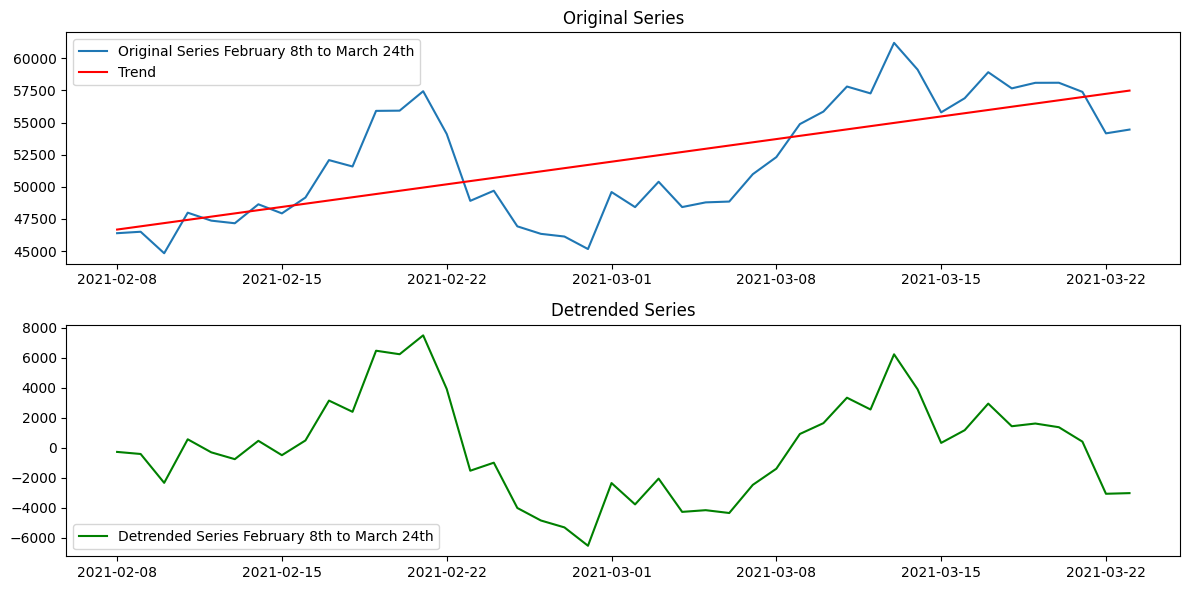

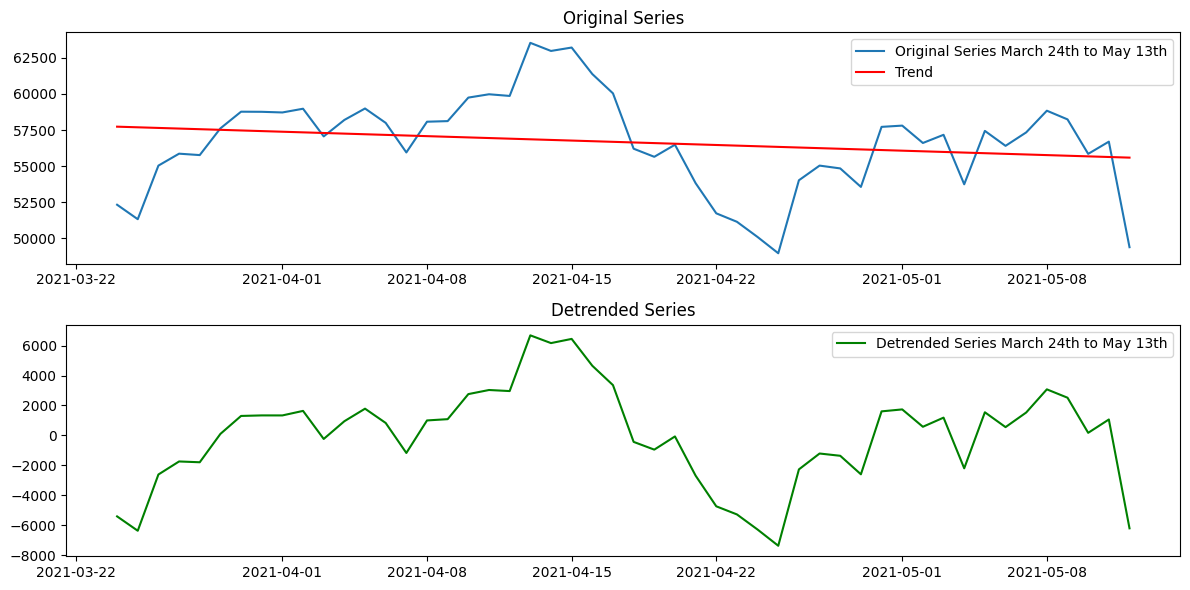

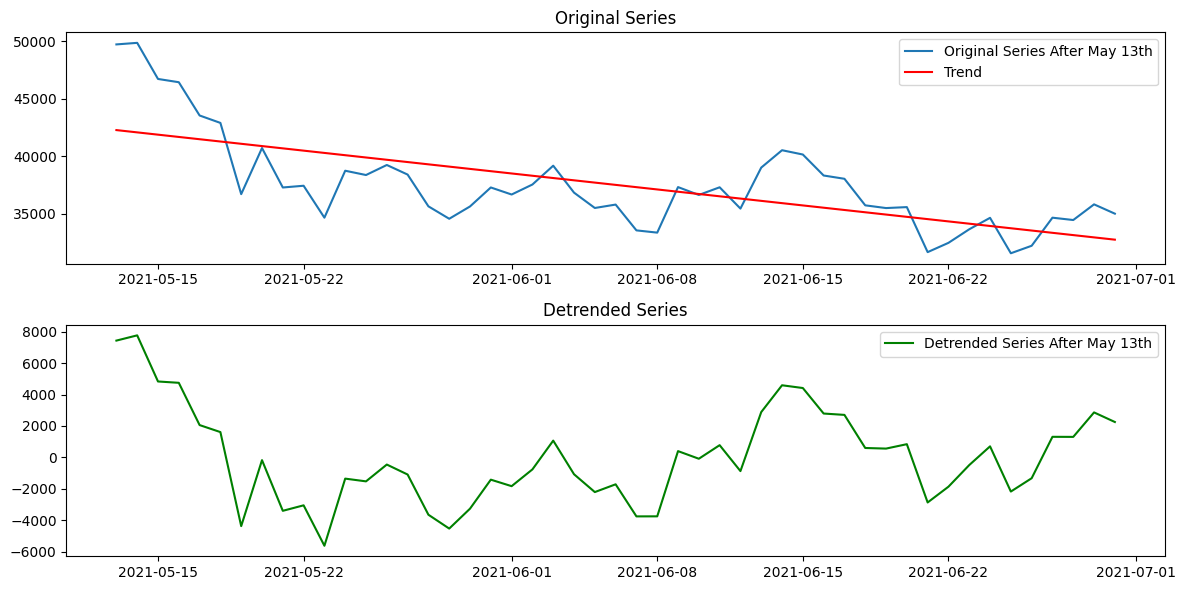

In [ ]:
# plot the trend for data before key_date_0
plot_trend(data_0, title='Januray to February 8th')

# plot the trend for data between key_date_0 and key_date_1
plot_trend(data_1, title='February 8th to March 24th')

# plot the trend for data between key_date_1 and key_date_2
plot_trend(data_2, title='March 24th to May 13th')

# plot the trend for data after key_date_2
plot_trend(data_3, title='After May 13th')

### Modeling

In [ ]:
def switchpoint_analysis(n_switchpoints):
    # create a PyMC3 model
    with pm.Model() as model:
        # define a function to create switchpoints
        def create_switchpoint(id, lower, upper):
            return pm.DiscreteUniform(f'switchpoint_{id}', lower=lower, upper=upper)

        # define a function to create rates (average as a free parameter)
        def create_rate(id, lower, upper):
            return pm.Uniform(f'rate_{id}', lower=lower, upper=upper)

        # define a function to build the switch logic
        def build_switch(id):
            if id == 0:
                return pm.math.switch(switchpoints[0] >= days, rates[id], rates[id+1])
            else:
                return pm.math.switch(switchpoints[id] >= days, build_switch(id-1), rates[id+1])

        # create a list to store switchpoints
        switchpoints = [create_switchpoint(0, 0, 181)]
        for i in range(1, n_switchpoints):
            switchpoints.append(create_switchpoint(i, switchpoints[i-1]+1, len(data)-n_switchpoints+i))

        # create a list to store rates
        rates = []
        for i in range(0, n_switchpoints+1):
            rates.append(create_rate(i, 30000, 65000))

        # generate an array of days
        days = np.arange(0, len(data))

        # define the variance (for Negative Binomial distribution)
        variance = pm.Uniform('variance', 1, 25000)

        # build the rate using the switch logic
        rate = build_switch(n_switchpoints-1)

        # define the observation model with Negative Binomial distribution
        observation = pm.NegativeBinomial('obs', rate, variance, observed=data['value'])

    return model

In [ ]:
def visualization(n_switchpoints):
    # generate an array of plot dates
    plot_dates = np.arange(0, len(data))

    # calculate posterior quantiles
    posterior_quantile = np.percentile(prediction["obs"], [2.5, 25, 50, 75, 97.5], axis=0)

    # plot the posterior median
    plt.plot(
        plot_dates, posterior_quantile[2, :],
        color='b', label='posterior median', lw=2)

    # fill the area between 2.5th and 97.5th percentiles
    plt.fill_between(
        plot_dates, posterior_quantile[0, :], posterior_quantile[4, :],
        color='b', label='95% quantile', alpha=.2)

    # plot the observed data
    plt.plot(
        plot_dates, data,
        '--o', color='k', markersize=3,
        label='Observed', alpha=.8)

    # plot vertical lines for switchpoints
    for j in range(n_switchpoints):
        plt.vlines(np.median(trace["posterior"]["switchpoint_%s" % j]), data['value'].min(), data['value'].max(), color='C1')

    # adjust x-axis ticks to avoid overlap
    plt.xticks(np.arange(0, len(data), step=len(data) // 10), rotation=45)
    plt.ylabel('Steps', fontsize='large')
    plt.xlabel('Day', fontsize='large')
    plt.title('With %s switchpoints' % n_switchpoints)

    # set legend font size
    fontsize = 'medium'
    plt.legend(loc='upper left', fontsize=fontsize)

    # adjust layout and display plot
    plt.tight_layout()
    plt.show()

#### 2 Switchpoints

In [ ]:
# create the steps model with 2 switchpoints
with switchpoint_analysis(2) as model:
    # perform MCMC sampling
    trace = pm.sample(10000, tune=5000, init='jitter+adapt_diag', return_inferencedata=True)

In [ ]:
# calculate the summary statistics of the trace with a 95% HDI probability
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
switchpoint_0,37.014,0.138,37.000,37.000,0.003,0.002,3121.0,2580.0,1.0
switchpoint_1,135.342,0.674,135.000,137.000,0.012,0.009,3253.0,3375.0,1.0
rate_0,35204.480,479.999,34305.525,36173.917,2.768,1.958,29998.0,14122.0,1.0
rate_1,54224.304,463.616,53301.437,55115.973,3.035,2.146,23333.0,14295.0,1.0
rate_2,36540.545,467.987,35610.373,37438.324,3.420,2.418,18714.0,13576.0,1.0
variance,146.155,15.502,115.486,175.756,0.101,0.073,23689.0,14176.0,1.0


array([[<Axes: title={'center': 'variance'}>,
        <Axes: title={'center': 'variance'}>]], dtype=object)

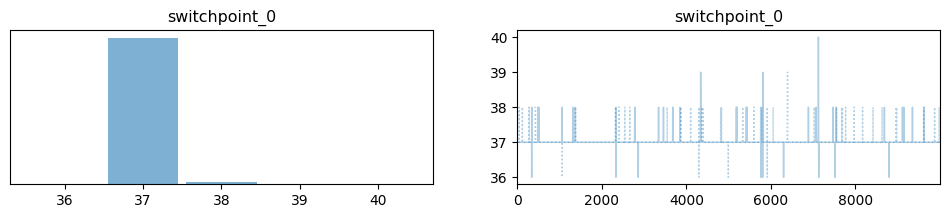

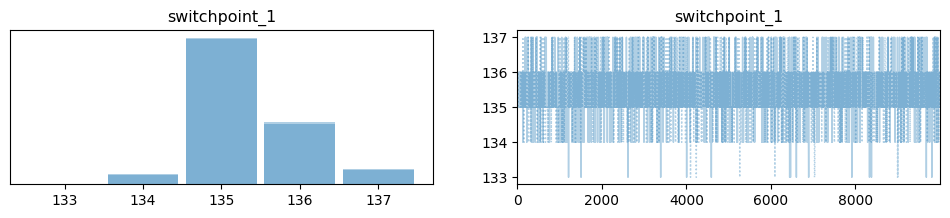

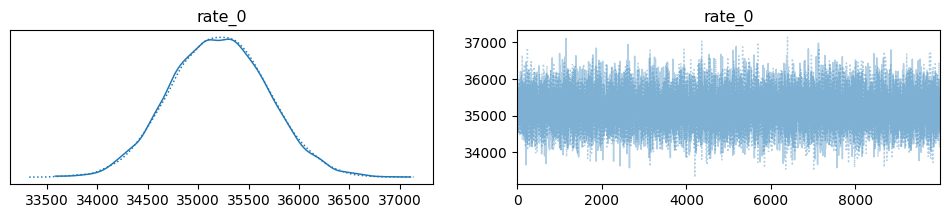

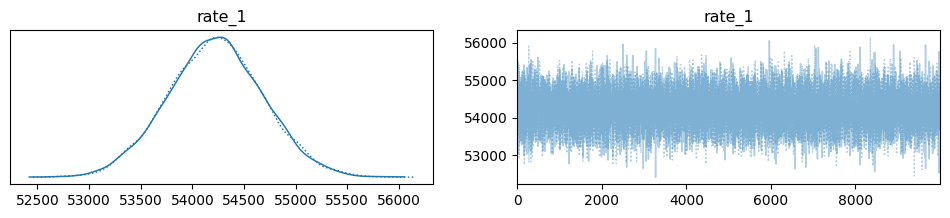

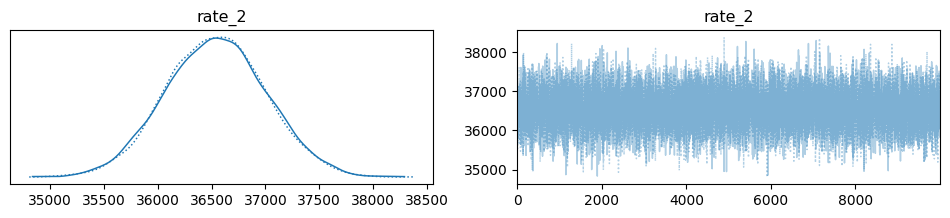

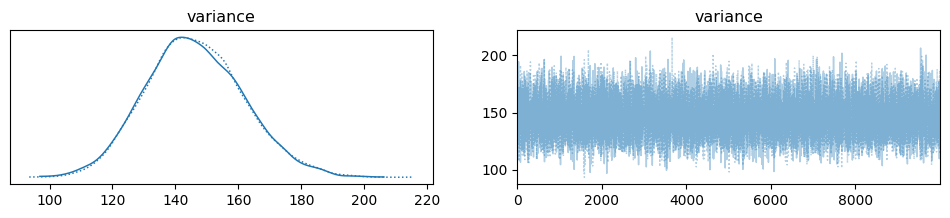

In [ ]:
# plot traces for switchpoint 0
az.plot_trace(trace, var_names="switchpoint_0")

# plot traces for switchpoint 1
az.plot_trace(trace, var_names="switchpoint_1")

# plot traces for rate 0
az.plot_trace(trace, var_names="rate_0")

# plot traces for rate 1
az.plot_trace(trace, var_names="rate_1")

# plot traces for rate 2
az.plot_trace(trace, var_names="rate_2")

# plot traces for variance
az.plot_trace(trace, var_names="variance")

In [ ]:
# generate posterior predictive samples with 2 switchpoints
with switchpoint_analysis(2) as model:
    prediction = pm.sample_posterior_predictive(trace, 10000)

/usr/local/lib/python3.10/dist-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


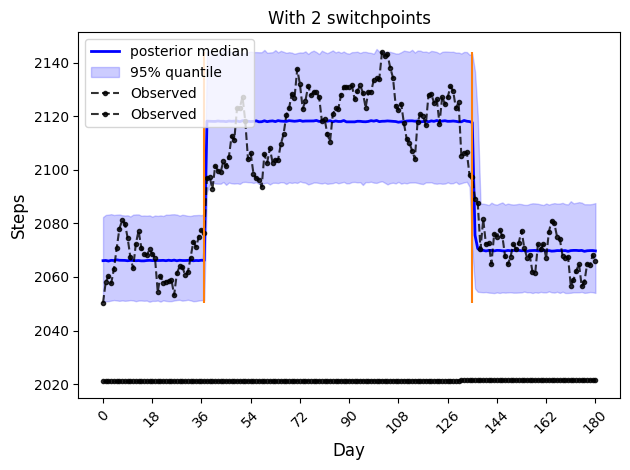

In [ ]:
# display the plot layout with 2 switchpoints
visualization(2)

#### 3 Switchpoints

In [ ]:
# create steps model with 3 switchpoints and perform MCMC sampling
with switchpoint_analysis(3) as model:
    # perform MCMC sampling with 10000 samples and 5000 tuning steps
    trace = pm.sample(10000, tune=5000, init='jitter+adapt_diag', return_inferencedata=True)

ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
# calculate summary statistics of the trace with a 95% HDI probability
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
switchpoint_0,37.008,0.105,37.000,37.000,0.002,0.001,2681.0,2495.0,1.00
switchpoint_1,133.367,2.054,130.000,136.000,1.227,0.980,3.0,12.0,1.77
switchpoint_2,152.855,15.688,136.000,170.000,11.010,9.299,3.0,30.0,1.92
rate_0,35203.534,463.138,34259.785,36086.763,3.047,2.154,23080.0,15033.0,1.00
rate_1,54371.721,467.068,53477.160,55302.116,86.022,61.445,29.0,1289.0,1.04
rate_2,41624.091,4513.096,36261.816,48810.191,2973.997,2447.971,3.0,40.0,1.80
rate_3,35259.323,1837.818,32683.941,37098.648,794.077,595.270,3.0,40.0,1.64
variance,156.812,16.824,123.571,189.257,0.147,0.105,13348.0,14860.0,1.00


array([[<Axes: title={'center': 'variance'}>,
        <Axes: title={'center': 'variance'}>]], dtype=object)

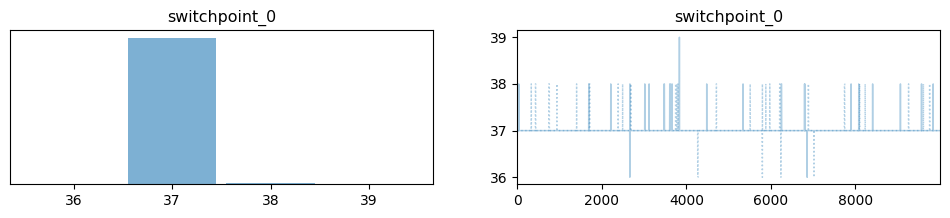

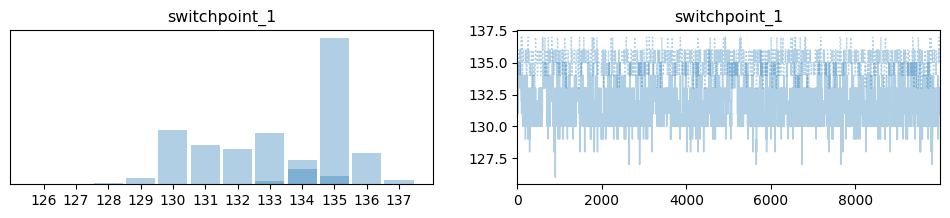

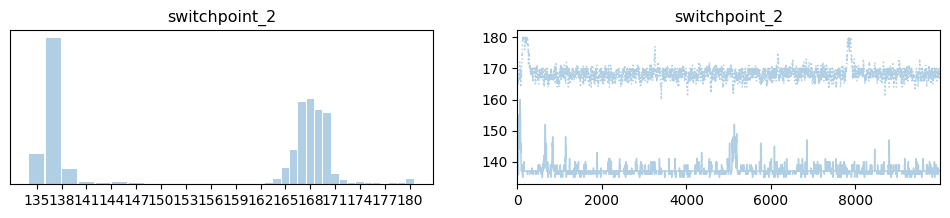

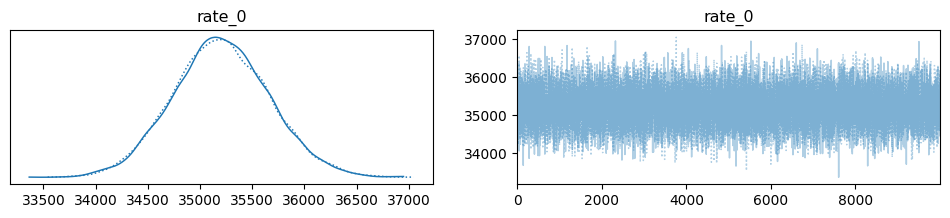

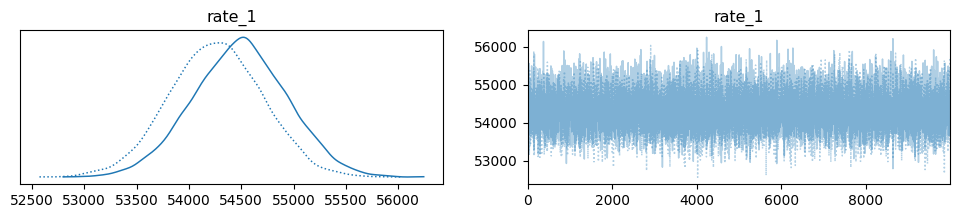

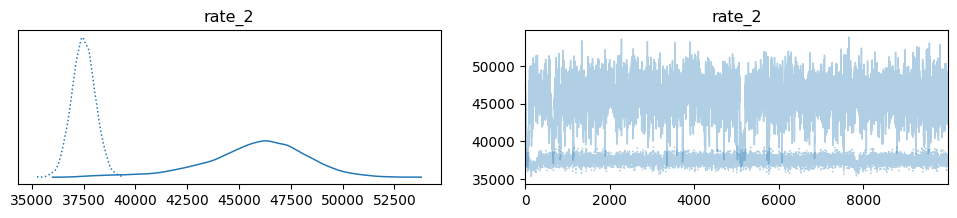

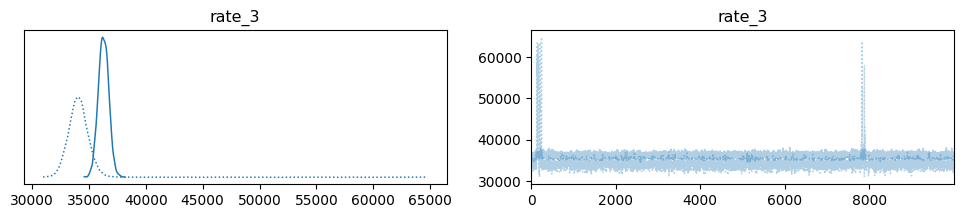

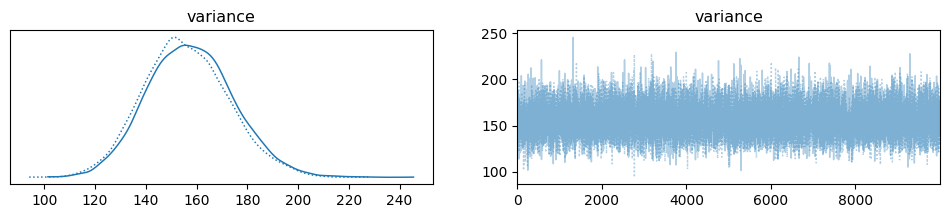

In [ ]:
# plot traces for switchpoint 0
az.plot_trace(trace, var_names="switchpoint_0")

# plot traces for switchpoint 1
az.plot_trace(trace, var_names="switchpoint_1")

# plot traces for switchpoint 2
az.plot_trace(trace, var_names="switchpoint_2")

# plot traces for rate 0
az.plot_trace(trace, var_names="rate_0")

# plot traces for rate 1
az.plot_trace(trace, var_names="rate_1")

# plot traces for rate 2
az.plot_trace(trace, var_names="rate_2")

# plot traces for rate 3
az.plot_trace(trace, var_names="rate_3")

# plot traces for variance
az.plot_trace(trace, var_names="variance")

In [ ]:
# generate posterior predictive samples with 3 switchpoints
with switchpoint_analysis(3) as model:
    prediction = pm.sample_posterior_predictive(trace, 10000)

/usr/local/lib/python3.10/dist-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


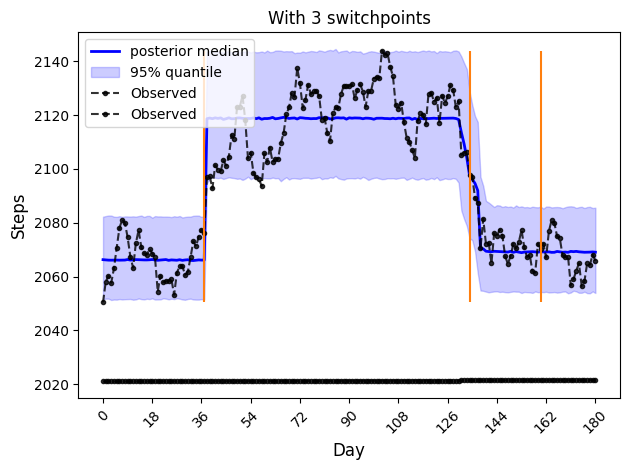

In [ ]:
# display the plot layout with 3 switchpoints
visualization(3)